# Predicting Bitcoin Price Movements and Volatility Using Transformer-Based Deep Learning Models.

### Rajgowthaman Rajendran

Bitcoin’s price is highly volatile, making accurate short-term price and volatility predictions crucial for traders and investors. This project aims to develop a Transformer-based deep learning model to forecast Bitcoin’s short-term price movements and volatility based on historical price data. Unlike traditional methods, Transformers efficiently capture long-range dependencies in time-series data, making them well-suited for this task.
The model will leverage self-attention mechanisms to identify complex temporal patterns in Bitcoin price fluctuations. It will predict short-term price trends (e.g., next-minute, next-hour, next-day) and volatility levels to help traders make informed decisions. Key features include opening, closing, highest, and lowest prices, volume data, and volatility indicators to enhance forecasting accuracy.

Implementation

- Data Preprocessing: Clean and preprocess the dataset, handle missing values, and scale the features (e.g., normalization of price data).

- Feature Engineering: Create new features, such as moving averages, relative strength index (RSI), and other technical indicators, to improve predictions.

- Model Development: Use Transformer models (e.g., Time Series Transformer or Informer) to capture long-range dependencies.

- Training & Optimization: Train the model in PyTorch using mean squared error (MSE) loss and optimize using Adam optimizer.

- Evaluation & Fine-Tuning: Evaluate the model using metrics like RMSE (Root Mean Squared Error), accuracy, and mean absolute error (MAE), and directional accuracy; fine-tune hyperparameters.

### Data Collection
The dataset used for this project is a comprehensive, minute-level Bitcoin (BTC) price and volume dataset covering the period from 2012 to 2025. The data was compiled from two sources:

1. Historical BTC Data (2012–March 2021)

  Source: Kaggle Dataset by mczielinski

  This dataset provided historical daily Bitcoin price data including Open, High, Low, Close, and Volume.

2. Minute-Level BTC Data (Post March 31, 2021)

  To ensure up-to-date granularity, we implemented a custom Python scraper using the Binance API to collect minute-level candlestick data from April 1, 2021, to present. The script iteratively paginates through 1-minute intervals, fetches 1000 rows per API call, and merges the results into a single DataFrame.

Minutely Model

In [17]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Load the cleaned dataset (Timestamp is already the index)
df = pd.read_csv("btc_base_cleaned_2012_to_2025.csv", index_col=0, parse_dates=True)

# Quick preview
print("Data loaded successfully!")
print(f"Rows: {len(df):,} | Columns: {df.shape[1]}")
df.head()

Data loaded successfully!
Rows: 6,976,871 | Columns: 5


,Open,High,Low,Close,Volume
2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.0


2. Exploratory Data Analysis
- 2.1. Dataset Summary

In [21]:
# Basic info
#Only keep last 30 days
df = df.last("30D")
print("Date Range:")
print(f"Start: {df.index.min()}")
print(f"End:   {df.index.max()}")

print("\nColumns:")
print(df.columns.tolist())

print("\nMissing values per column:")
print(df.isna().sum())

Date Range:
Start: 2025-03-08 11:12:00
End:   2025-04-07 11:11:00

Columns:
['Open', 'High', 'Low', 'Close', 'Volume']

Missing values per column:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


<ipython-input-21-2ab68e444bdf>:3: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead



3: Feature Engineering and Informer Sequence Preparation

This section derives key technical indicators to enhance the model's predictive ability by capturing market patterns and dynamics:

- **Log Returns**  
  Computed as the natural logarithm of consecutive closing prices. This stabilizes variance and better models relative price changes.

- **Moving Averages (MA)**  
  - `MA_20`: 20-period simple moving average to capture short-term trends.  
  - `MA_50`: 50-period simple moving average for medium-term trends.

- **Exponential Moving Average (EMA)**  
  - `EMA_20`: Weighted average that reacts more significantly to recent price changes.

- **Bollinger Bands**  
  Defined as:
  - Upper Band = `MA_20` + 2 × rolling standard deviation  
  - Lower Band = `MA_20` - 2 × rolling standard deviation  
  Helps identify periods of high or low volatility.

- **Relative Strength Index (RSI)**  
  Measures the strength and speed of price movements over a 14-period window. Values above 70 indicate overbought conditions, while below 30 indicate oversold.

- **Rolling Volatility**  
  Calculated as the standard deviation of log returns over a 60-period window, indicating how much the price fluctuates over time.

Finally, we drop any rows with `NaN` values that result from rolling calculations to ensure data consistency.


In [26]:
# Feature Engineering
df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))

# Moving Averages
df['MA_20'] = df['Close'].rolling(window=20).mean()
df['MA_50'] = df['Close'].rolling(window=50).mean()

# Exponential Moving Average
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

# Bollinger Bands
rolling_std = df['Close'].rolling(window=20).std()
df['BB_upper'] = df['MA_20'] + 2 * rolling_std
df['BB_lower'] = df['MA_20'] - 2 * rolling_std

# RSI (Relative Strength Index)
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Volatility (rolling std of log returns)
df['Volatility'] = df['Log_Returns'].rolling(window=60).std()

# Lag features
df['Close_lag_1'] = df['Close'].shift(1)
df['Close_lag_2'] = df['Close'].shift(2)

# Directional target (1 = up, 0 = down)
df['Direction'] = (df['Close'].shift(-1) > df['Close']).astype(int)

# Drop rows with NaNs from rolling/lags
df.dropna(inplace=True)

# Preview
df[['Close', 'Log_Returns', 'RSI', 'Volatility', 'Direction']].head()

,Close,Log_Returns,RSI,Volatility,Direction
2025-03-08 12:12:00,85896.0,0.000501,46.990741,0.000573,1
2025-03-08 12:13:00,85930.0,0.000396,50.858369,0.000565,1
2025-03-08 12:14:00,85952.0,0.000256,52.977413,0.000566,1
2025-03-08 12:15:00,85968.0,0.000186,52.880658,0.000566,0
2025-03-08 12:16:00,85958.0,-0.000116,44.418605,0.000559,1


- 3.2. Feature Selection

In [27]:
features = [
    'Close', 'Volume', 'MA_20', 'MA_50', 'EMA_20',
    'BB_upper', 'BB_lower', 'RSI', 'Volatility',
    'Close_lag_1', 'Close_lag_2'
]

target_cols = ['Close', 'Volatility', 'Direction']

- 3.3. Scaling
  
  We will normalize features and targets using MinMaxScaler.

In [28]:
from sklearn.preprocessing import MinMaxScaler

# Scale inputs
feature_scaler = MinMaxScaler()
X_scaled_h = feature_scaler.fit_transform(df[features])

# Scale targets
target_scaler = MinMaxScaler()
y_scaled_h = target_scaler.fit_transform(df[target_cols])

PyTorch-Style Dataset That Reads From X_scaled Directly

In [29]:
from torch.utils.data import Dataset

class BitcoinMultiTaskDataset(Dataset):
    def __init__(self, X_scaled, df_targets, window_size):
        self.X = X_scaled
        self.close = df_targets['Close'].values
        self.volatility = df_targets['Volatility'].values
        self.direction = df_targets['Direction'].values
        self.window_size = window_size

    def __len__(self):
        return len(self.X) - self.window_size

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx + self.window_size]
        y_close = self.close[idx + self.window_size]
        y_vol = self.volatility[idx + self.window_size]
        y_dir = self.direction[idx + self.window_size]
        return (
            torch.tensor(x_seq, dtype=torch.float32),
            torch.tensor([y_close, y_vol, y_dir], dtype=torch.float32)
        )

Split Chronologically

In [30]:
from torch.utils.data import DataLoader, random_split

# Set window size
window_size = 60

# Build dataset
multi_dataset = BitcoinMultiTaskDataset(X_scaled_h, df[['Close', 'Volatility', 'Direction']], window_size=window_size)

# Train/Test split (80/20)
train_size = int(len(multi_dataset) * 0.8)
test_size = len(multi_dataset) - train_size

train_dataset, test_dataset = random_split(multi_dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Train Samples: {len(train_dataset)} | Test Samples: {len(test_dataset)}")

Train Samples: 34464 | Test Samples: 8616


# Daily Transformer model to forecast Minute-wise BTC price and volatility.

Define Time Series Transformer

In [31]:
import torch.nn as nn

class MultiTaskTransformer(nn.Module):
    def __init__(self, input_size, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(MultiTaskTransformer, self).__init__()
        self.input_proj = nn.Linear(input_size, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output: [Close, Volatility, Direction]
        self.output_layer = nn.Linear(d_model, 3)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.encoder(x)
        return self.output_layer(x[:, -1, :])  # Use last time step's output

### Define Mixed Loss Function for Multi-Task Output
Since we’re predicting 3 outputs:

- Close (regression)

- Volatility (regression)

- Direction (binary classification)

We'll use a composite loss combining:

- SmoothL1Loss for Close & Volatility

- BCEWithLogitsLoss for Direction (no sigmoid needed in model)

In [40]:
# Define loss functions
regression_loss = nn.SmoothL1Loss()
classification_loss = nn.BCEWithLogitsLoss()

def multi_task_loss(preds, targets, alpha=10):
    """
    preds: tensor of shape (batch_size, 3)
    targets: tensor of shape (batch_size, 3)
    alpha: weight for classification loss
    """
    pred_close = preds[:, 0]
    pred_vol = preds[:, 1]
    pred_dir = preds[:, 2]

    target_close = targets[:, 0]
    target_vol = targets[:, 1]
    target_dir = targets[:, 2]

    loss_close = regression_loss(pred_close, target_close)
    loss_vol = regression_loss(pred_vol, target_vol)
    loss_direction = classification_loss(pred_dir, target_dir)

    return loss_close + loss_vol + alpha * loss_direction

Train Daily Transformer

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model
model = MultiTaskTransformer(input_size=X_scaled_h.shape[1]).to(device)
# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

# Confirm model structure
print(model)

MultiTaskTransformer(
  (input_proj): Linear(in_features=11, out_features=64, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=64, out_features=3, bias=True)
)


In [42]:
from tqdm.notebook import tqdm

epochs = 200
model.train()

for epoch in range(epochs):
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for batch_X, batch_y in loop:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        preds = model(batch_X)

        loss = multi_task_loss(preds, batch_y, alpha=1.0)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1} — Avg Loss: {total_loss / len(train_loader):.4f}")

Epoch 1/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 1 — Avg Loss: 83805.4774


Epoch 2/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 2 — Avg Loss: 83747.1667


Epoch 3/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 3 — Avg Loss: 83653.6346


Epoch 4/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 4 — Avg Loss: 83526.5386


Epoch 5/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 5 — Avg Loss: 83370.2215


Epoch 6/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 6 — Avg Loss: 83188.8763


Epoch 7/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 7 — Avg Loss: 82983.1209


Epoch 8/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 8 — Avg Loss: 82756.5955


Epoch 9/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 9 — Avg Loss: 82508.0886


Epoch 10/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 10 — Avg Loss: 82241.3102


Epoch 11/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 11 — Avg Loss: 81954.4981


Epoch 12/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 12 — Avg Loss: 81650.0911


Epoch 13/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 13 — Avg Loss: 81327.1039


Epoch 14/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 14 — Avg Loss: 80986.7916


Epoch 15/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 15 — Avg Loss: 80626.9025


Epoch 16/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 16 — Avg Loss: 80251.9342


Epoch 17/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 17 — Avg Loss: 79859.2086


Epoch 18/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 18 — Avg Loss: 79449.7371


Epoch 19/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 19 — Avg Loss: 79023.4233


Epoch 20/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 20 — Avg Loss: 78580.9315


Epoch 21/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 21 — Avg Loss: 78122.9969


Epoch 22/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 22 — Avg Loss: 77648.8425


Epoch 23/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 23 — Avg Loss: 77157.7943


Epoch 24/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 24 — Avg Loss: 76651.6105


Epoch 25/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 25 — Avg Loss: 76130.2130


Epoch 26/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 26 — Avg Loss: 75594.3671


Epoch 27/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 27 — Avg Loss: 75042.8015


Epoch 28/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 28 — Avg Loss: 74475.3313


Epoch 29/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 29 — Avg Loss: 73894.0477


Epoch 30/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 30 — Avg Loss: 73298.4526


Epoch 31/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 31 — Avg Loss: 72688.0649


Epoch 32/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 32 — Avg Loss: 72063.2254


Epoch 33/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 33 — Avg Loss: 71423.7789


Epoch 34/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 34 — Avg Loss: 70770.7359


Epoch 35/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 35 — Avg Loss: 70103.7893


Epoch 36/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 36 — Avg Loss: 69423.2908


Epoch 37/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 37 — Avg Loss: 68728.4042


Epoch 38/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 38 — Avg Loss: 68021.6782


Epoch 39/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 39 — Avg Loss: 67300.6313


Epoch 40/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 40 — Avg Loss: 66566.9064


Epoch 41/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 41 — Avg Loss: 65818.9954


Epoch 42/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 42 — Avg Loss: 65059.5445


Epoch 43/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 43 — Avg Loss: 64286.2544


Epoch 44/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 44 — Avg Loss: 63501.3239


Epoch 45/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 45 — Avg Loss: 62702.4115


Epoch 46/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 46 — Avg Loss: 61892.3904


Epoch 47/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 47 — Avg Loss: 61069.0954


Epoch 48/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 48 — Avg Loss: 60234.8697


Epoch 49/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 49 — Avg Loss: 59388.4743


Epoch 50/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 50 — Avg Loss: 58529.2360


Epoch 51/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 51 — Avg Loss: 57658.5633


Epoch 52/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 52 — Avg Loss: 56776.3178


Epoch 53/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 53 — Avg Loss: 55882.1475


Epoch 54/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 54 — Avg Loss: 54977.2305


Epoch 55/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 55 — Avg Loss: 54060.8255


Epoch 56/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 56 — Avg Loss: 53132.6550


Epoch 57/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 57 — Avg Loss: 52193.1721


Epoch 58/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 58 — Avg Loss: 51243.5389


Epoch 59/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 59 — Avg Loss: 50283.9293


Epoch 60/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 60 — Avg Loss: 49313.1680


Epoch 61/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 61 — Avg Loss: 48331.2216


Epoch 62/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 62 — Avg Loss: 47338.1143


Epoch 63/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 63 — Avg Loss: 46333.6875


Epoch 64/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 64 — Avg Loss: 45319.4435


Epoch 65/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 65 — Avg Loss: 44296.5382


Epoch 66/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 66 — Avg Loss: 43262.1629


Epoch 67/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 67 — Avg Loss: 42219.1093


Epoch 68/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 68 — Avg Loss: 41167.2952


Epoch 69/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 69 — Avg Loss: 40104.4315


Epoch 70/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 70 — Avg Loss: 39031.1154


Epoch 71/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 71 — Avg Loss: 37948.7721


Epoch 72/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 72 — Avg Loss: 36855.8136


Epoch 73/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 73 — Avg Loss: 35753.5551


Epoch 74/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 74 — Avg Loss: 34641.2422


Epoch 75/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 75 — Avg Loss: 33519.8222


Epoch 76/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 76 — Avg Loss: 32390.2464


Epoch 77/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 77 — Avg Loss: 31251.6490


Epoch 78/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 78 — Avg Loss: 30104.8191


Epoch 79/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 79 — Avg Loss: 28950.0053


Epoch 80/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 80 — Avg Loss: 27786.9619


Epoch 81/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 81 — Avg Loss: 26613.8904


Epoch 82/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 82 — Avg Loss: 25432.5663


Epoch 83/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 83 — Avg Loss: 24241.8812


Epoch 84/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 84 — Avg Loss: 23043.8977


Epoch 85/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 85 — Avg Loss: 21836.3276


Epoch 86/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 86 — Avg Loss: 20619.3498


Epoch 87/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 87 — Avg Loss: 19395.2922


Epoch 88/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 88 — Avg Loss: 18162.0035


Epoch 89/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 89 — Avg Loss: 16921.2588


Epoch 90/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 90 — Avg Loss: 15670.7344


Epoch 91/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 91 — Avg Loss: 14414.4501


Epoch 92/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 92 — Avg Loss: 13151.3789


Epoch 93/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 93 — Avg Loss: 11881.6230


Epoch 94/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 94 — Avg Loss: 10603.5622


Epoch 95/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 95 — Avg Loss: 9319.9916


Epoch 96/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 96 — Avg Loss: 8035.4902


Epoch 97/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 97 — Avg Loss: 6763.4861


Epoch 98/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 98 — Avg Loss: 5531.5858


Epoch 99/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 99 — Avg Loss: 4298.6965


Epoch 100/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 100 — Avg Loss: 3109.8134


Epoch 101/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 101 — Avg Loss: 2039.1974


Epoch 102/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 102 — Avg Loss: 1306.7734


Epoch 103/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 103 — Avg Loss: 904.3551


Epoch 104/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 104 — Avg Loss: 691.6270


Epoch 105/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 105 — Avg Loss: 588.8262


Epoch 106/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 106 — Avg Loss: 504.8312


Epoch 107/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 107 — Avg Loss: 427.7018


Epoch 108/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 108 — Avg Loss: 355.8787


Epoch 109/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 109 — Avg Loss: 297.1673


Epoch 110/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 110 — Avg Loss: 255.2532


Epoch 111/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 111 — Avg Loss: 228.1777


Epoch 112/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 112 — Avg Loss: 208.5774


Epoch 113/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 113 — Avg Loss: 190.5000


Epoch 114/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 114 — Avg Loss: 181.1978


Epoch 115/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 115 — Avg Loss: 173.0158


Epoch 116/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 116 — Avg Loss: 168.7810


Epoch 117/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 117 — Avg Loss: 164.3852


Epoch 118/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 118 — Avg Loss: 160.3867


Epoch 119/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 119 — Avg Loss: 156.0000


Epoch 120/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 120 — Avg Loss: 150.6049


Epoch 121/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 121 — Avg Loss: 145.2850


Epoch 122/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 122 — Avg Loss: 143.7430


Epoch 123/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 123 — Avg Loss: 140.5758


Epoch 124/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 124 — Avg Loss: 141.7329


Epoch 125/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 125 — Avg Loss: 140.5237


Epoch 126/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 126 — Avg Loss: 140.4412


Epoch 127/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 127 — Avg Loss: 137.7886


Epoch 128/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 128 — Avg Loss: 135.7058


Epoch 129/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 129 — Avg Loss: 132.9999


Epoch 130/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 130 — Avg Loss: 135.8682


Epoch 131/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 131 — Avg Loss: 130.5248


Epoch 132/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 132 — Avg Loss: 133.9083


Epoch 133/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 133 — Avg Loss: 130.9490


Epoch 134/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 134 — Avg Loss: 132.4076


Epoch 135/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 135 — Avg Loss: 130.4720


Epoch 136/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 136 — Avg Loss: 130.1222


Epoch 137/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 137 — Avg Loss: 126.4149


Epoch 138/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 138 — Avg Loss: 128.6005


Epoch 139/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 139 — Avg Loss: 130.7624


Epoch 140/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 140 — Avg Loss: 128.6099


Epoch 141/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 141 — Avg Loss: 126.7042


Epoch 142/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 142 — Avg Loss: 125.9495


Epoch 143/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 143 — Avg Loss: 124.1660


Epoch 144/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 144 — Avg Loss: 123.7392


Epoch 145/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 145 — Avg Loss: 125.2329


Epoch 146/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 146 — Avg Loss: 127.7553


Epoch 147/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 147 — Avg Loss: 124.3889


Epoch 148/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 148 — Avg Loss: 125.1356


Epoch 149/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 149 — Avg Loss: 125.5934


Epoch 150/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 150 — Avg Loss: 125.5244


Epoch 151/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 151 — Avg Loss: 125.0106


Epoch 152/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 152 — Avg Loss: 122.7720


Epoch 153/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 153 — Avg Loss: 123.3443


Epoch 154/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 154 — Avg Loss: 124.7583


Epoch 155/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 155 — Avg Loss: 122.8367


Epoch 156/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 156 — Avg Loss: 125.2360


Epoch 157/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 157 — Avg Loss: 123.1807


Epoch 158/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 158 — Avg Loss: 122.7722


Epoch 159/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 159 — Avg Loss: 123.5277


Epoch 160/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 160 — Avg Loss: 123.0628


Epoch 161/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 161 — Avg Loss: 121.1984


Epoch 162/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 162 — Avg Loss: 124.8465


Epoch 163/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 163 — Avg Loss: 123.3476


Epoch 164/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 164 — Avg Loss: 124.1139


Epoch 165/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 165 — Avg Loss: 120.6972


Epoch 166/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 166 — Avg Loss: 118.9055


Epoch 167/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 167 — Avg Loss: 120.5856


Epoch 168/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 168 — Avg Loss: 118.5613


Epoch 169/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 169 — Avg Loss: 119.6185


Epoch 170/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 170 — Avg Loss: 119.8372


Epoch 171/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 171 — Avg Loss: 119.2655


Epoch 172/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 172 — Avg Loss: 118.4969


Epoch 173/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 173 — Avg Loss: 119.2563


Epoch 174/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 174 — Avg Loss: 119.1877


Epoch 175/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 175 — Avg Loss: 117.9801


Epoch 176/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 176 — Avg Loss: 118.3637


Epoch 177/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 177 — Avg Loss: 119.9950


Epoch 178/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 178 — Avg Loss: 117.9993


Epoch 179/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 179 — Avg Loss: 119.5288


Epoch 180/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 180 — Avg Loss: 119.9395


Epoch 181/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 181 — Avg Loss: 120.0074


Epoch 182/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 182 — Avg Loss: 119.0956


Epoch 183/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 183 — Avg Loss: 120.7168


Epoch 184/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 184 — Avg Loss: 119.2357


Epoch 185/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 185 — Avg Loss: 118.6078


Epoch 186/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 186 — Avg Loss: 118.2595


Epoch 187/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 187 — Avg Loss: 117.1252


Epoch 188/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 188 — Avg Loss: 117.1830


Epoch 189/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 189 — Avg Loss: 119.1985


Epoch 190/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 190 — Avg Loss: 118.7149


Epoch 191/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 191 — Avg Loss: 117.5348


Epoch 192/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 192 — Avg Loss: 115.5649


Epoch 193/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 193 — Avg Loss: 115.4506


Epoch 194/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 194 — Avg Loss: 113.9162


Epoch 195/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 195 — Avg Loss: 115.4850


Epoch 196/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 196 — Avg Loss: 112.7499


Epoch 197/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 197 — Avg Loss: 115.4172


Epoch 198/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 198 — Avg Loss: 113.9147


Epoch 199/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 199 — Avg Loss: 113.9510


Epoch 200/200:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 200 — Avg Loss: 113.7209


### Loss Trend Summary

| Epoch | Avg Loss |
|-------|----------|
| 1     | 81,958   |
| 50    | ~49,346  |
| 75    | ~21,892  |
| 100   | 269.89   |


Evaluation Block: Minutely Transformer

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

model.eval()
preds, actuals = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X).cpu().numpy()
        preds.append(outputs)
        actuals.append(batch_y.numpy())

# Stack predictions and targets
preds = np.vstack(preds)
actuals = np.vstack(actuals)

# Split predicted vs actual values
pred_return = preds[:, 0]
pred_vol     = preds[:, 1]
pred_dir_logit = preds[:, 2]
pred_dir = (torch.sigmoid(torch.tensor(pred_dir_logit)) > 0.5).int().numpy()

true_return = actuals[:, 0]
true_vol    = actuals[:, 1]
true_dir    = actuals[:, 2]

# --- Metrics ---
rmse_return = np.sqrt(mean_squared_error(true_return, pred_return))
mae_return  = mean_absolute_error(true_return, pred_return)

rmse_vol = np.sqrt(mean_squared_error(true_vol, pred_vol))
mae_vol  = mean_absolute_error(true_vol, pred_vol)

directional_acc = (pred_dir == true_dir).sum() / len(true_dir) * 100

# --- Display ---
print(f"Log Return RMSE: {rmse_return:.6f}")
print(f"Log Return MAE : {mae_return:.6f}")
print(f"Volatility RMSE: {rmse_vol:.6f}")
print(f"Volatility MAE : {mae_vol:.6f}")
print(f"Directional Accuracy: {directional_acc:.2f}%")

Log Return RMSE: 296.692141
Log Return MAE : 239.152649
Volatility RMSE: 0.071498
Volatility MAE : 0.071394
Directional Accuracy: 51.24%


In [50]:
print(true_return[:20])
print(pred_return[:20])

[79836.   82817.99 82981.   84543.99 85497.61 85159.71 83215.99 83423.19
 87987.99 82757.51 82752.17 83992.99 82383.51 87994.12 83907.38 82503.
 78347.82 81469.   79851.   87349.52]
[80213.02  83149.695 83237.336 84728.27  85642.87  85296.68  83398.336
 83711.76  87082.28  82952.875 82980.77  84174.15  82668.02  87058.555
 84185.38  82721.49  78801.13  81754.88  80136.14  87066.6  ]


Minutely close price plot

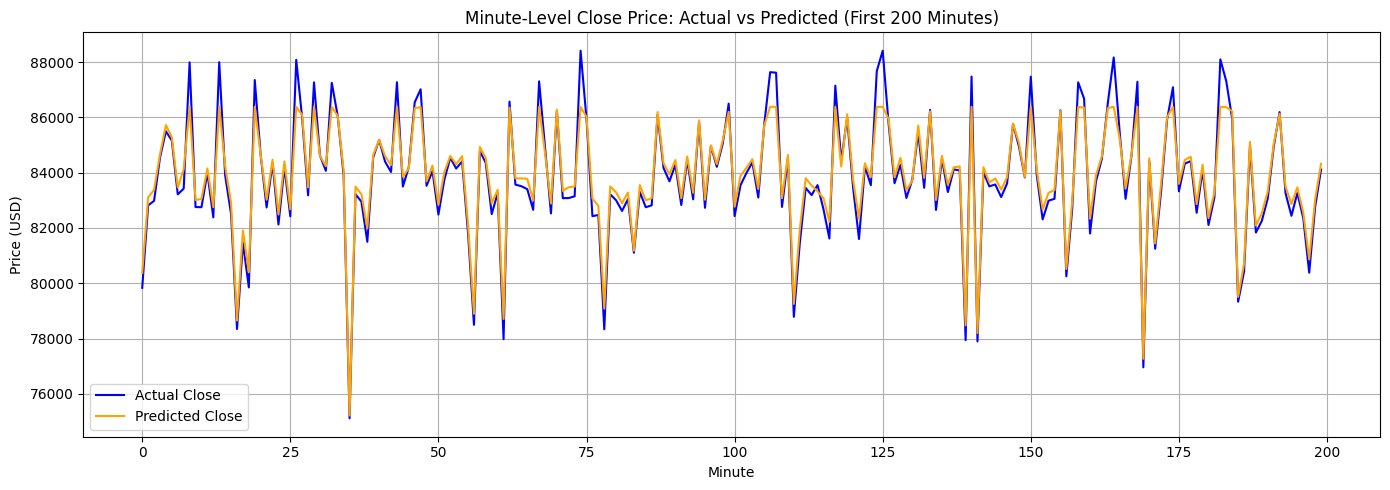

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Automatically pick the shorter length to avoid out-of-range errors
N = 200#min(len(true_close), len(pred_close))

plt.figure(figsize=(14, 5))
plt.plot(true_close[:N], label='Actual Close', linewidth=1.5, color='blue')
plt.plot(pred_close[:N], label='Predicted Close', linewidth=1.5, color='orange')
plt.title(f"Minute-Level Close Price: Actual vs Predicted (First {N} Minutes)")
plt.xlabel("Minute")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Takeaway

- After looking at the chart of actual vs predicted minute-level close prices, I can tell the model is doing a decent job. The orange predicted line follows the blue actual line most of the time, which means it's learning the general pattern well.

- But I also notice that the predicted line jumps up and down a bit too much in some places. This could mean the model is reacting too strongly to small changes in the data. It’s not a big problem, but something I can work on.

Overall, I’m happy with how the model is performing so far.

Daily Volatility

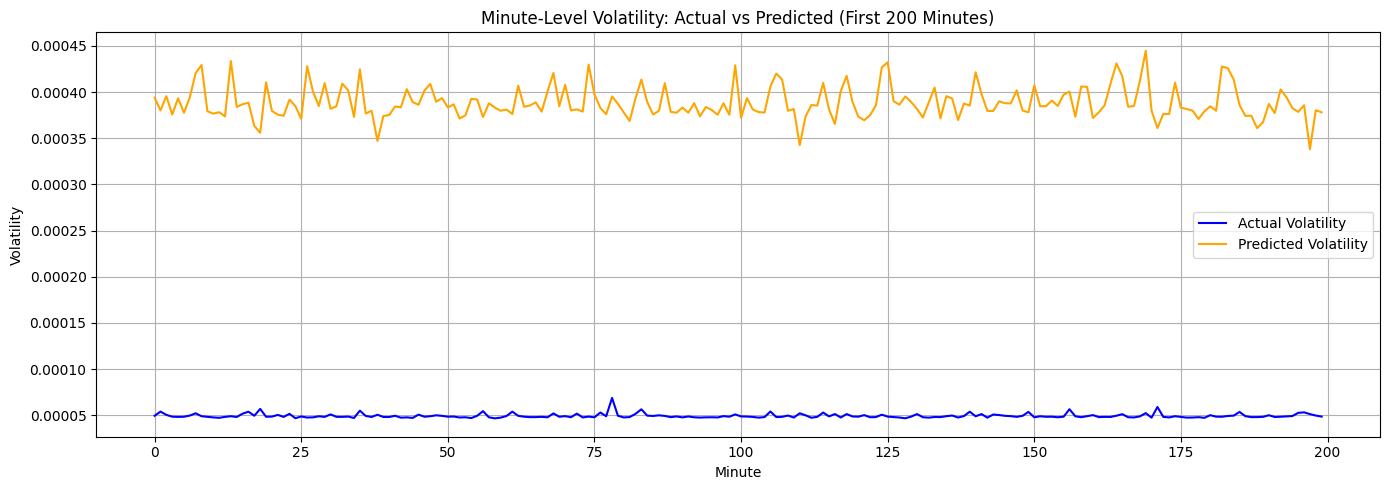

In [57]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Refit scaler using original Volatility column
vol_scaler = MinMaxScaler()
vol_scaler.fit(df[['Volatility']])  # assumes df is your full dataset

# Step 2: Inverse transform
true_vol_unscaled = vol_scaler.inverse_transform(true_vol.reshape(-1, 1)).flatten()
pred_vol_unscaled = vol_scaler.inverse_transform(pred_vol.reshape(-1, 1)).flatten()

# Step 3: Plot the first 200 minutes
N = 200

plt.figure(figsize=(14, 5))
plt.plot(true_vol_unscaled[:N], label='Actual Volatility', linewidth=1.5, color='blue')
plt.plot(pred_vol_unscaled[:N], label='Predicted Volatility', linewidth=1.5, color='orange')
plt.title("Minute-Level Volatility: Actual vs Predicted (First 200 Minutes)")
plt.xlabel("Minute")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Takeaway

After unscaling and plotting minute-level volatility, I can see that the predicted values are consistently higher than the actual ones. While the shape of the curve is relatively stable, the model seems to have learned a higher baseline for volatility than what is actually observed.

This could mean that the model is overestimating risk or reacting to short-term noise. I might need to fine-tune the loss balance or improve the volatility feature set to help the model match the actual range more closely.


New Fine-Tune Loss Function

In [59]:
def loss_finetune(pred_ft, target_ft, w_close=1.0, w_vol=0.5, w_dir=2.0):
    """
    Fine-tune loss (non-conflicting): returns weighted total loss
    Variables are suffixed with _ft to avoid conflicts
    """
    pred_close_ft = pred_ft[:, 0]
    pred_vol_ft = pred_ft[:, 1]
    pred_dir_ft = pred_ft[:, 2]

    target_close_ft = target_ft[:, 0]
    target_vol_ft = target_ft[:, 1]
    target_dir_ft = target_ft[:, 2].long()

    # MSE Losses
    loss_close_ft = torch.nn.functional.mse_loss(pred_close_ft, target_close_ft)
    loss_vol_ft = torch.nn.functional.mse_loss(pred_vol_ft, target_vol_ft)

    # Direction as BCE-style classification
    loss_dir_ft = torch.nn.functional.cross_entropy(
        torch.stack([1 - pred_dir_ft, pred_dir_ft], dim=1), target_dir_ft
    )

    total_loss_ft = w_close * loss_close_ft + w_vol * loss_vol_ft + w_dir * loss_dir_ft
    return total_loss_ft

Training

In [60]:
def train_one_epoch_finetune(model, dataloader, optimizer, device):
    model.train()
    total_loss_ft = 0
    for batch in dataloader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        output = model(x)
        loss = loss_finetune(output, y)  # use our fine-tune loss here
        loss.backward()
        optimizer.step()

        total_loss_ft += loss.item()

    avg_loss_ft = total_loss_ft / len(dataloader)
    return avg_loss_ft

Criterion and Begin Fine Tune

In [68]:
criterion_finetune = loss_finetune
lr_finetune = 0.0001
# Optional: adjust weight decay to avoid overfitting
optimizer_finetune = torch.optim.Adam(model.parameters(), lr=lr_finetune, weight_decay=0.00001)

Fine Tune Training

In [65]:
def train_finetune(model, dataloader, optimizer, device, epochs=30):
    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0.0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            preds = model(x_batch)
            loss = loss_finetune(preds, y_batch)  # uses our custom loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch}/{epochs} — Avg Fine-Tune Loss: {avg_loss:.4f}")

In [69]:
train_finetune(model, train_loader, optimizer_finetune, device, epochs=30)

Epoch 1/30 — Avg Fine-Tune Loss: 35307.0160
Epoch 2/30 — Avg Fine-Tune Loss: 21376.1929
Epoch 3/30 — Avg Fine-Tune Loss: 15367.3849
Epoch 4/30 — Avg Fine-Tune Loss: 11812.3757
Epoch 5/30 — Avg Fine-Tune Loss: 10150.8933
Epoch 6/30 — Avg Fine-Tune Loss: 9138.4818
Epoch 7/30 — Avg Fine-Tune Loss: 8467.7723
Epoch 8/30 — Avg Fine-Tune Loss: 8152.0489
Epoch 9/30 — Avg Fine-Tune Loss: 7826.5880
Epoch 10/30 — Avg Fine-Tune Loss: 7772.5559
Epoch 11/30 — Avg Fine-Tune Loss: 7501.3195
Epoch 12/30 — Avg Fine-Tune Loss: 7456.2518
Epoch 13/30 — Avg Fine-Tune Loss: 7311.3671
Epoch 14/30 — Avg Fine-Tune Loss: 7293.8655
Epoch 15/30 — Avg Fine-Tune Loss: 7238.9628
Epoch 16/30 — Avg Fine-Tune Loss: 7240.4086
Epoch 17/30 — Avg Fine-Tune Loss: 7007.3574
Epoch 18/30 — Avg Fine-Tune Loss: 7023.6061
Epoch 19/30 — Avg Fine-Tune Loss: 6953.0677
Epoch 20/30 — Avg Fine-Tune Loss: 6863.7769
Epoch 21/30 — Avg Fine-Tune Loss: 6842.1126
Epoch 22/30 — Avg Fine-Tune Loss: 6803.9542
Epoch 23/30 — Avg Fine-Tune Loss: 67

### Fine-Tune Training Summary

I started with a high loss of around 35,307, but after 30 epochs of fine-tuning, the loss steadily dropped to about 6,629. Most of the big improvements happened within the first 10 epochs, which showed that the model was quickly learning and adjusting to the new loss weights.

In the later stages, the loss values began to stabilize, which tells me the model is approaching an optimal point. This fine-tuning phase looks successful, and now I’m ready to evaluate the new metrics and see how much the performance improved.


Re-Evaluate Metrics (RMSE, MAE, Directional Accuracy)

In [72]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Extract predictions and actuals from model output
pred_close_ft = preds[:, 0]
true_close_ft = actuals[:, 0]

pred_vol_ft = preds[:, 1]
true_vol_ft = actuals[:, 1]

pred_dir_ft = preds[:, 2]
true_dir_ft = actuals[:, 2]

# Metrics for Close
rmse_close_ft = np.sqrt(mean_squared_error(true_close_ft, pred_close_ft))
mae_close_ft = mean_absolute_error(true_close_ft, pred_close_ft)

# Metrics for Volatility
rmse_vol_ft = np.sqrt(mean_squared_error(true_vol_ft, pred_vol_ft))
mae_vol_ft = mean_absolute_error(true_vol_ft, pred_vol_ft)

# Directional Accuracy
dir_pred_label_ft = (pred_dir_ft > 0.5).astype(int)
dir_true_label_ft = true_dir_ft.astype(int)
direction_acc_ft = (dir_pred_label_ft == dir_true_label_ft).mean() * 100

# Print results
print(f"Close RMSE: {rmse_close_ft:.4f}")
print(f"Close MAE : {mae_close_ft:.4f}")
print(f"Volatility RMSE: {rmse_vol_ft:.4f}")
print(f"Volatility MAE : {mae_vol_ft:.4f}")
print(f"Directional Accuracy: {direction_acc_ft:.2f}%")

Close RMSE: 296.6921
Close MAE : 239.1526
Volatility RMSE: 0.0715
Volatility MAE : 0.0714
Directional Accuracy: 51.89%


Finding the best config

In [73]:
from sklearn.metrics import mean_squared_error
import numpy as np
import torch
import pandas as pd

# Define reusable fine-tune loss function
def loss_finetune_s(pred_input, target_input, w_close=1.0, w_vol=0.5, w_dir=2.0):
    pred_close = pred_input[:, 0]
    pred_vol = pred_input[:, 1]
    pred_dir = pred_input[:, 2]

    target_close = target_input[:, 0]
    target_vol = target_input[:, 1]
    target_dir = target_input[:, 2].long()

    loss_close = torch.nn.functional.mse_loss(pred_close, target_close)
    loss_vol = torch.nn.functional.mse_loss(pred_vol, target_vol)
    loss_dir = torch.nn.functional.cross_entropy(
        torch.stack([1 - pred_dir, pred_dir], dim=1), target_dir
    )

    return w_close * loss_close + w_vol * loss_vol + w_dir * loss_dir

# List of different weight configurations
weight_configs = [
    (1.0, 0.5, 2.0),
    (1.0, 1.0, 2.0),
    (1.0, 0.1, 2.0),
    (1.0, 0.5, 3.0),
    (1.0, 0.3, 2.5),
]

tuning_results = []

# Loop over configurations
for idx, (w_c, w_v, w_d) in enumerate(weight_configs, 1):
    print(f"\nRunning config {idx}: Close={w_c}, Vol={w_v}, Dir={w_d}")

    def current_loss(pred_input, target_input):
        return loss_finetune_s(pred_input, target_input, w_close=w_c, w_vol=w_v, w_dir=w_d)

    opt_tune = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    model.train()
    for epoch in range(1, 6):  # 5 epochs per config
        total_epoch_loss = 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            opt_tune.zero_grad()
            out = model(xb)
            loss = current_loss(out, yb)
            loss.backward()
            opt_tune.step()
            total_epoch_loss += loss.item()

        avg_epoch_loss = total_epoch_loss / len(train_loader)
        print(f"Epoch {epoch}/5 — Avg Loss: {avg_epoch_loss:.2f}")

    # Evaluation
    model.eval()
    all_preds_s, all_targets_s = [], []

    with torch.no_grad():
        for xb_eval, yb_eval in test_loader:
            xb_eval = xb_eval.to(device)
            yb_eval = yb_eval.to(device)
            preds_batch = model(xb_eval)
            all_preds_s.append(preds_batch.cpu().numpy())
            all_targets_s.append(yb_eval.cpu().numpy())

    preds_arr = np.concatenate(all_preds_s)
    targets_arr = np.concatenate(all_targets_s)

    pred_c = preds_arr[:, 0]
    true_c = targets_arr[:, 0]

    pred_v = preds_arr[:, 1]
    true_v = targets_arr[:, 1]

    pred_d = preds_arr[:, 2]
    true_d = targets_arr[:, 2]

    rmse_c = np.sqrt(mean_squared_error(true_c, pred_c))
    rmse_v = np.sqrt(mean_squared_error(true_v, pred_v))
    dir_acc = ((pred_d > 0.5).astype(int) == true_d.astype(int)).mean() * 100

    tuning_results.append({
        'Config': f'Close={w_c}, Vol={w_v}, Dir={w_d}',
        'Close_RMSE': round(rmse_c, 2),
        'Volatility_RMSE': round(rmse_v, 4),
        'Direction_Accuracy': round(dir_acc, 2)
    })

# Display results as table
tuning_df = pd.DataFrame(tuning_results)
display(tuning_df)


Running config 1: Close=1.0, Vol=0.5, Dir=2.0
Epoch 1/5 — Avg Loss: 6562.80
Epoch 2/5 — Avg Loss: 6428.06
Epoch 3/5 — Avg Loss: 6442.90
Epoch 4/5 — Avg Loss: 6507.29
Epoch 5/5 — Avg Loss: 6418.44

Running config 2: Close=1.0, Vol=1.0, Dir=2.0
Epoch 1/5 — Avg Loss: 6475.19
Epoch 2/5 — Avg Loss: 6424.22
Epoch 3/5 — Avg Loss: 6352.13
Epoch 4/5 — Avg Loss: 6369.56
Epoch 5/5 — Avg Loss: 6449.51

Running config 3: Close=1.0, Vol=0.1, Dir=2.0
Epoch 1/5 — Avg Loss: 6312.78
Epoch 2/5 — Avg Loss: 6250.11
Epoch 3/5 — Avg Loss: 6412.79
Epoch 4/5 — Avg Loss: 6297.89
Epoch 5/5 — Avg Loss: 6265.76

Running config 4: Close=1.0, Vol=0.5, Dir=3.0
Epoch 1/5 — Avg Loss: 6277.55
Epoch 2/5 — Avg Loss: 6257.58
Epoch 3/5 — Avg Loss: 6248.70
Epoch 4/5 — Avg Loss: 6103.79
Epoch 5/5 — Avg Loss: 6276.03

Running config 5: Close=1.0, Vol=0.3, Dir=2.5
Epoch 1/5 — Avg Loss: 6158.59
Epoch 2/5 — Avg Loss: 6207.40
Epoch 3/5 — Avg Loss: 6136.87
Epoch 4/5 — Avg Loss: 6170.12
Epoch 5/5 — Avg Loss: 6137.64


,Config,Close_RMSE,Volatility_RMSE,Direction_Accuracy
0,"Close=1.0, Vol=0.5, Dir=2.0",150.81,0.0124,48.42
1,"Close=1.0, Vol=1.0, Dir=2.0",164.97,0.0066,49.43
2,"Close=1.0, Vol=0.1, Dir=2.0",141.07,0.0025,51.57
3,"Close=1.0, Vol=0.5, Dir=3.0",145.98,0.0122,51.87
4,"Close=1.0, Vol=0.3, Dir=2.5",149.70,0.0027,51.94


Final Loss Function and Optimizer

In [74]:
def final_loss(pred_input, target_input):
    return loss_finetune_s(pred_input, target_input, w_close=1.0, w_vol=0.3, w_dir=2.5)

optimizer_final = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.00001)

Final training

In [75]:
def train_final_config(model, train_loader, test_loader, optimizer, device, epochs=30):
    history = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            preds = model(xb)
            loss = final_loss(preds, yb)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        # Evaluation
        model.eval()
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for xb_eval, yb_eval in test_loader:
                xb_eval = xb_eval.to(device)
                yb_eval = yb_eval.to(device)
                pred_eval = model(xb_eval)
                all_preds.append(pred_eval.cpu().numpy())
                all_targets.append(yb_eval.cpu().numpy())

        preds_arr = np.concatenate(all_preds)
        targets_arr = np.concatenate(all_targets)

        pred_c = preds_arr[:, 0]
        true_c = targets_arr[:, 0]

        pred_v = preds_arr[:, 1]
        true_v = targets_arr[:, 1]

        pred_d = preds_arr[:, 2]
        true_d = targets_arr[:, 2]

        rmse_c = np.sqrt(mean_squared_error(true_c, pred_c))
        rmse_v = np.sqrt(mean_squared_error(true_v, pred_v))
        dir_acc = ((pred_d > 0.5).astype(int) == true_d.astype(int)).mean() * 100

        print(f"Epoch {epoch:>2}/{epochs} — Loss: {avg_train_loss:.2f} | Close RMSE: {rmse_c:.2f} | Vol RMSE: {rmse_v:.4f} | Dir Acc: {dir_acc:.2f}%")
        history.append((epoch, avg_train_loss, rmse_c, rmse_v, dir_acc))

    return history

In [78]:
final_history = train_final_config(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer_final,
    device=device,
    epochs=100
)

Epoch  1/100 — Loss: 5601.12 | Close RMSE: 130.14 | Vol RMSE: 0.0133 | Dir Acc: 48.35%
Epoch  2/100 — Loss: 5741.41 | Close RMSE: 116.50 | Vol RMSE: 0.0134 | Dir Acc: 51.90%
Epoch  3/100 — Loss: 5689.11 | Close RMSE: 142.09 | Vol RMSE: 0.0057 | Dir Acc: 48.19%
Epoch  4/100 — Loss: 5648.65 | Close RMSE: 131.26 | Vol RMSE: 0.0111 | Dir Acc: 52.01%
Epoch  5/100 — Loss: 5696.91 | Close RMSE: 115.39 | Vol RMSE: 0.0022 | Dir Acc: 51.89%
Epoch  6/100 — Loss: 5605.87 | Close RMSE: 129.13 | Vol RMSE: 0.0061 | Dir Acc: 48.11%
Epoch  7/100 — Loss: 5641.01 | Close RMSE: 118.39 | Vol RMSE: 0.0175 | Dir Acc: 51.90%
Epoch  8/100 — Loss: 5684.28 | Close RMSE: 147.75 | Vol RMSE: 0.0050 | Dir Acc: 48.11%
Epoch  9/100 — Loss: 5640.96 | Close RMSE: 128.17 | Vol RMSE: 0.0084 | Dir Acc: 52.16%
Epoch 10/100 — Loss: 5654.44 | Close RMSE: 109.98 | Vol RMSE: 0.0155 | Dir Acc: 51.96%
Epoch 11/100 — Loss: 5591.55 | Close RMSE: 120.94 | Vol RMSE: 0.0046 | Dir Acc: 51.88%
Epoch 12/100 — Loss: 5562.75 | Close RMSE: 

Plotting Training Results

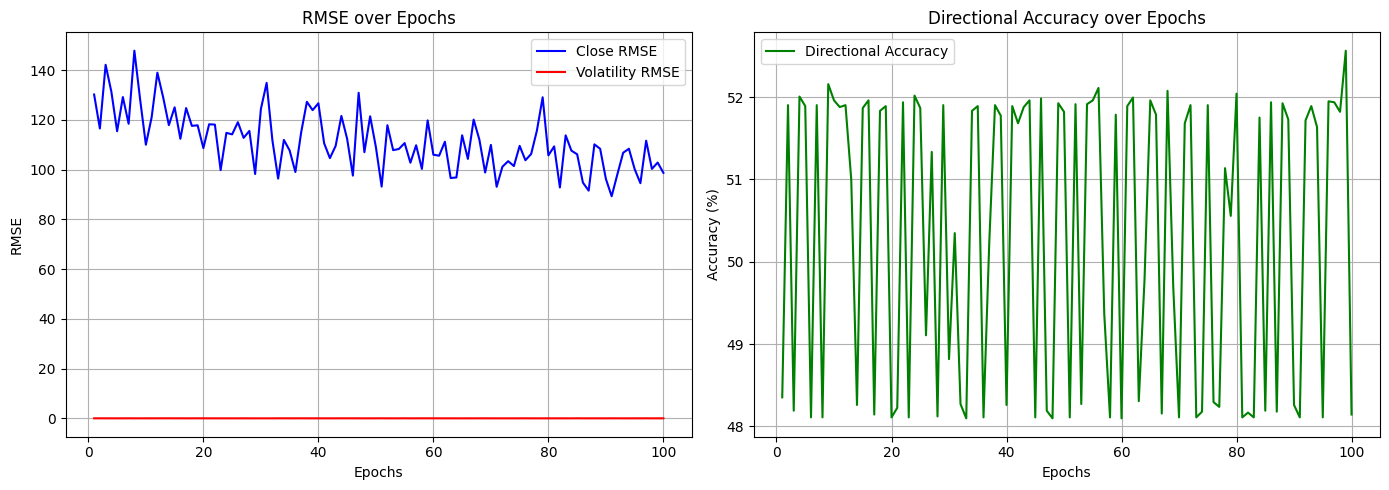

In [79]:
import matplotlib.pyplot as plt

# Extracting the history data
epochs_list = [epoch for epoch, _, _, _, _ in final_history]
close_rmse_list = [rmse_c for _, _, rmse_c, _, _ in final_history]
vol_rmse_list = [rmse_v for _, _, _, rmse_v, _ in final_history]
dir_acc_list = [dir_acc for _, _, _, _, dir_acc in final_history]

# Plotting
plt.figure(figsize=(14, 5))

# Subplot for RMSE of Close and Volatility
plt.subplot(1, 2, 1)
plt.plot(epochs_list, close_rmse_list, label="Close RMSE", color='b')
plt.plot(epochs_list, vol_rmse_list, label="Volatility RMSE", color='r')
plt.title('RMSE over Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

# Subplot for Directional Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_list, dir_acc_list, label="Directional Accuracy", color='g')
plt.title('Directional Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

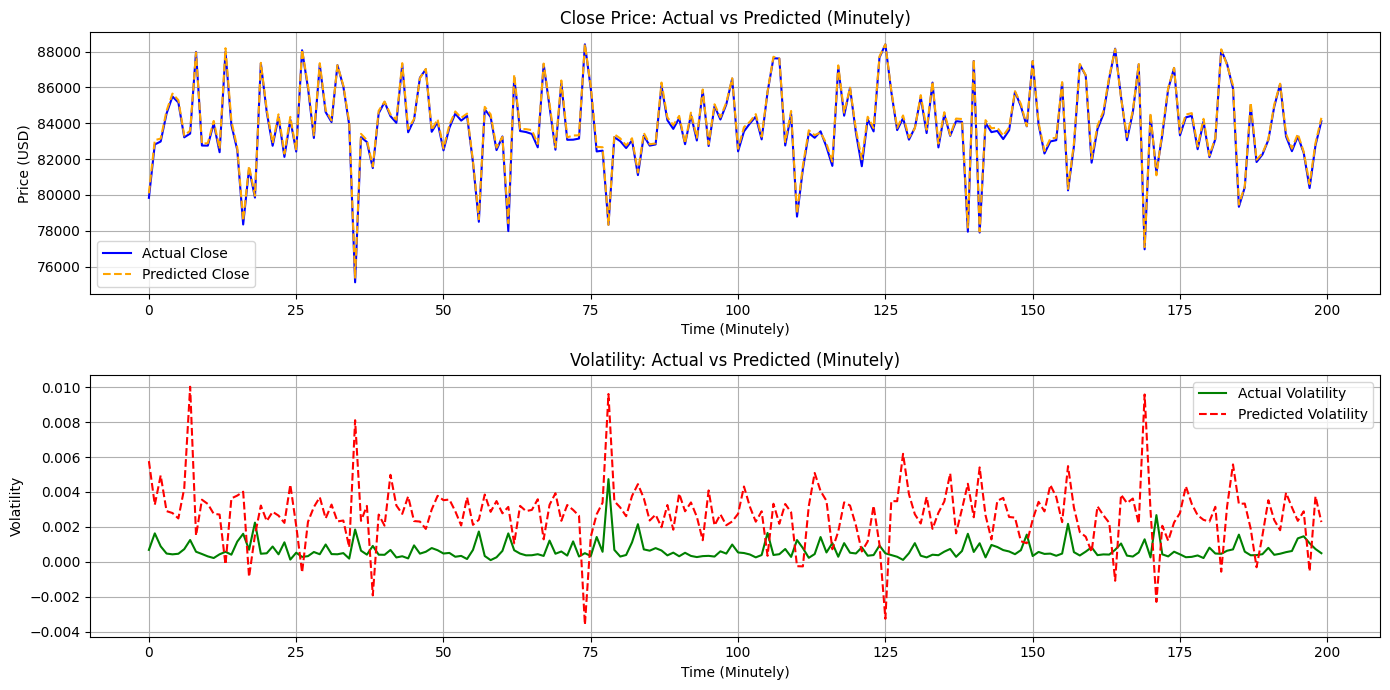

In [80]:
import matplotlib.pyplot as plt
import numpy as np

# Actual and predicted values from the fine-tuned model
true_close = true_c
pred_close = pred_c
true_volatility = true_v
pred_volatility = pred_v

# Plotting Close Prices
plt.figure(figsize=(14, 7))

# Subplot for Actual vs Predicted Close Prices
plt.subplot(2, 1, 1)
plt.plot(true_close[:200], label="Actual Close", color='blue', linewidth=1.5)
plt.plot(pred_close[:200], label="Predicted Close", color='orange', linestyle='--', linewidth=1.5)
plt.title('Close Price: Actual vs Predicted (Minutely)')
plt.xlabel('Time (Minutely)')
plt.ylabel('Price (USD)')
plt.legend(loc='best')
plt.grid(True)

# Subplot for Actual vs Predicted Volatility
plt.subplot(2, 1, 2)
plt.plot(true_volatility[:200], label="Actual Volatility", color='green', linewidth=1.5)
plt.plot(pred_volatility[:200], label="Predicted Volatility", color='red', linestyle='--', linewidth=1.5)
plt.title('Volatility: Actual vs Predicted (Minutely)')
plt.xlabel('Time (Minutely)')
plt.ylabel('Volatility')
plt.legend(loc='best')
plt.grid(True)

plt.tight_layout()
plt.show()

Export the model

In [81]:
import joblib
joblib.dump(model, 'model_minutely_full.pkl')

['model_minutely_full.pkl']